In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import gym

In [3]:
gym.envs.registry.all(), len(gym.envs.registry.all())

(dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvS

In [5]:
env = gym.make('CartPole-v1')

In [4]:
env.seed(123)
obs = env.reset()

In [5]:
obs

array([ 0.02078762, -0.01301236, -0.0209893 , -0.03935255])

In [6]:
env.render()

True

In [7]:
img = env.render(mode='rgb_array')
img.shape

(400, 600, 3)

In [9]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

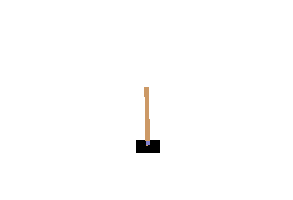

In [10]:
plot_environment(env)
plt.show()

In [11]:
env.action_space # 2 discrete action 0 and 1 for accelerate left or right

Discrete(2)

In [12]:
action = 1
obs, reward, done, info = env.step(action)

In [13]:
obs

array([ 0.02052737,  0.18240419, -0.02177635, -0.33858321])

In [14]:
reward

1.0

In [15]:
done

False

In [16]:
info

{}

## Hard Coded Policy

In [8]:
env.seed(123)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [18]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.706, 8.677071164857415, 24.0, 72.0)

In [19]:
env.seed(123)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [35]:
from matplotlib import animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.show()
    plt.close()
    return anim

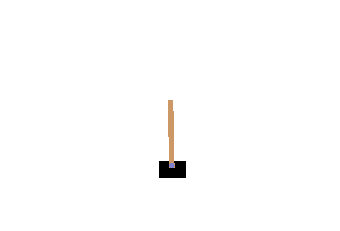

In [21]:
plot_animation(frames)
plt.show()

# Neural Network Policy

In [6]:
n_inputs = env.observation_space.shape[0]
n_inputs

4

In [9]:
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [11]:
def render_policy_net(model, n_max_steps=200, seed=123):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode='rgb_array'))
        left_probas = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand()>left_probas)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

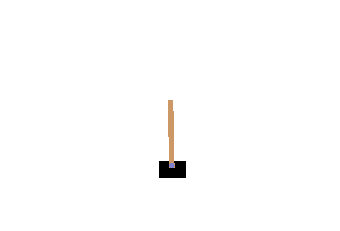

In [33]:
frames = render_policy_net(model)
plot_animation(frames)

In [11]:
n_envs = 50
n_iterations = 5000
envs = [gym.make('CartPole-v1') for _ in range(n_envs)]
for index, env in enumerate(envs):
    env.seed(index)

observations = [env.reset() for env in envs]
len(observations), np.array(observations).shape

(50, (50, 4))

In [12]:
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([[1. ] if obs[2]>0  else[0.] for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    actions = (np.random.rand(n_envs, 1)>left_probas.numpy()).astype(np.int32)
    for idx, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[idx][0])
        observations[idx] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.041

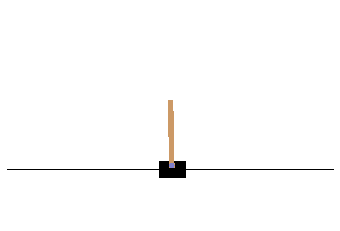

In [16]:
frames = render_policy_net(model)
plot_animation(frames)

# Policy Gradients

In [12]:
def play_one_step(env, obs, model, fn):
    with tf.GradientTape() as tape:
        left_probas =  model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_probas)
        target_y = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(fn(target_y, left_probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, rewards, done, info = env.step(int(action))
    return obs, rewards, done, grads

In [13]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_grads = []
    all_rewards = []
    for episode in range(n_episodes):
        current_grads = []
        current_rewards = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, rewards, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(rewards)
            current_grads.append(grads)
            if done:
                break
        all_grads.append(current_grads)
        all_rewards.append(current_rewards)
    return all_rewards, all_grads

In [14]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for i in range(len(rewards)-2, -1, -1):
        discounted[i] += discount_factor * discounted[i+1]
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(episode_rewards, discount_factor)
                                                 for episode_rewards in all_rewards]
    discounted_rewards_array = np.concatenate(all_discounted_rewards)
    all_rewards_mean = discounted_rewards_array.mean()
    all_rewards_std = discounted_rewards_array.std()
    action_advantages = [(discounted_rewards - all_rewards_mean) / all_rewards_std 
                                    for discounted_rewards in all_discounted_rewards]
    return action_advantages

In [104]:
discount_rewards([10, 0, -50], discount_factor=0.8), discount_rewards([10, 20], discount_factor=0.8)

(array([-22, -40, -50]), array([26, 20]))

In [105]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [56]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [57]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [58]:
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [118]:
env = gym.make("CartPole-v1")

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print("\rIteration: {}, mean rewards: {:.2f}".format(iteration, total_rewards / n_episodes_per_update), end="") 
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    for variable_index in range(len(model.trainable_variables)):
        mean_grad = tf.reduce_mean([step_reward * all_grads[episode][step][variable_index]
                                    for episode, episode_reward in enumerate(all_final_rewards)
                                    for step, step_reward in enumerate(episode_reward)], axis=0)
        all_mean_grads.append(mean_grad)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 194.80

# Markov Decision Process

In [72]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [[[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
          [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
          [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

### Q-Value Iteration

In [79]:
Q_values = np.full((3, 3), -np.inf) 
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 

In [80]:
gamma = 0.90

history = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([transition_probabilities[s][a] [s_]*
                                            (rewards[s][a][s_] + gamma*np.max(Q_values[s_])) for s_ in range(3)])

history = np.array(history)

In [81]:
Q_values

array([[18.91891892, 17.02702703, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [82]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

Try gamma = 0.95

In [83]:
Q_values = np.full((3, 3), -np.inf) 
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 

In [85]:
gamma = 0.95

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([transition_probabilities[s][a] [s_]*
                                            (rewards[s][a][s_] + gamma*np.max(Q_values[s_])) for s_ in range(3)])

In [86]:
Q_values

array([[21.79615996, 20.70635196, 16.76923123],
       [ 1.02074831,        -inf,  1.08097586],
       [       -inf, 53.77587186,        -inf]])

In [87]:
np.argmax(Q_values, axis=1)

array([0, 2, 1], dtype=int64)

# Q-Learning

In [3]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [4]:
def exploration_policy(step):
    return np.random.choice(possible_actions[step])

In [90]:
Q_values = np.full((3,3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state, action] = 0.0

alpha0 = 0.05
decay = 0.005 
gamma = 0.90 
state = 0 
history2 = [] 

for i in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + i*decay)
    Q_values[state, action] *= (1 - alpha)
    Q_values[state, action] += alpha* (reward + gamma*next_value)
    state = next_state
    
history2 = np.array(history2)

In [91]:
Q_values, history2[-1]

(array([[17.7160501 , 15.55280518, 12.32815634],
        [ 0.        ,        -inf, -9.03616828],
        [       -inf, 48.41967114,        -inf]]),
 array([[17.70798146, 15.55280518, 12.32815634],
        [ 0.        ,        -inf, -9.03616828],
        [       -inf, 48.41967114,        -inf]]))

In [92]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

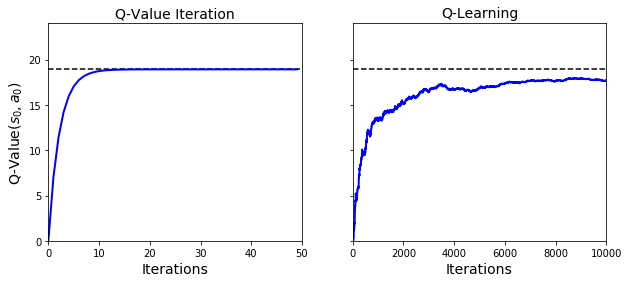

In [93]:
true_Q_value = history[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

## Deep Q-Network

In [7]:
env = gym.make("CartPole-v1")
input_shape = env.observation_space.shape
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [8]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand()<epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [9]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [10]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array([experience[idx] for experience in batch])
                                                      for idx in range(5)]
    return states, actions, rewards, next_states, dones

In [11]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [12]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1. - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [37]:
rewards = [] 
best_score = 0

In [38]:
for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 49, eps: 0.0100

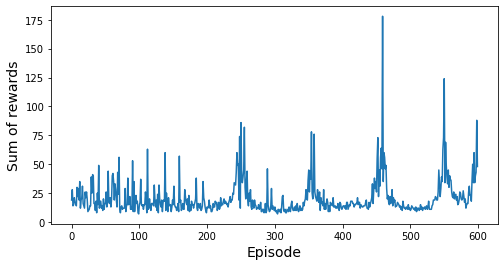

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

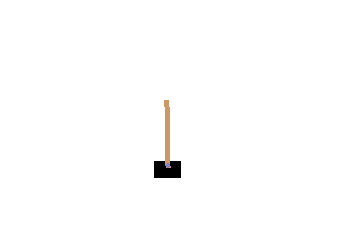

In [43]:
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)
plt.show()

## Dueling Double DQN

In [24]:
K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_value = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims = True)
Q_values = state_value + advantages
model = keras.models.Model(inputs = [input_states], outputs=[Q_values])

target_model = keras.models.clone_model(model)
target_model.set_weights(model.get_weights())
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 32)           160         input_6[0][0]                    
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 32)           1056        dense_21[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 2)            66          dense_22[0][0]                   
____________________________________________________________________________________________

In [31]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    mask = tf.one_hot(actions, n_outputs)
    max_value_actions = np.argmax(model.predict(next_states), axis=1)
    next_action_mask = tf.one_hot(max_value_actions, n_outputs)
    all_next_Q_values = target_model.predict(next_states)
    next_Q_values = tf.reduce_sum(all_next_Q_values * next_action_mask, axis=1, keepdims=True)
    target_Q_values = (rewards + (1 - dones) * discount_rate * next_Q_values)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = loss_fn(target_Q_values, Q_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [32]:
replay_memory = deque(maxlen=2000)

In [33]:
rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 ==0:
        target_model.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 28, eps: 0.0104

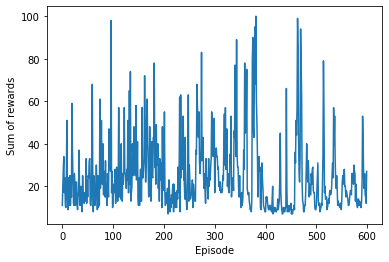

In [37]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

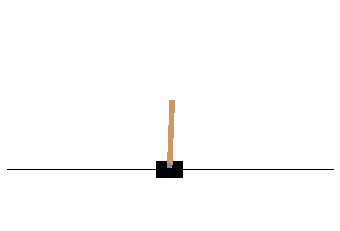

In [36]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)
plt.show()

In [38]:
env.close()

# TF-Agents Environments

In [1]:
from tf_agents.environments import suite_gym

env = suite_gym.load('Breakout-v4')
env

OSError: [WinError 126] The specified module could not be found
  In call to configurable 'load' (<function load at 0x00000211A5019AF8>)

In [3]:
import atari_py

OSError: [WinError 126] The specified module could not be found